In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import sqlalchemy
from shapely import wkt
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice
import pyodbc
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle(/) {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C',
          '#BFE9E7','#7a2700']
sns.set(font="Pragmatica")

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

In [4]:
def load_network_summary(filepath):
    """Load network-level results using a standard procedure. """
    df = pd.read_csv(filepath)

    # Congested network components by time of day
    df.columns

    # Get freeflow from 20to5 period

    # Exclude trips taken on non-designated facilities (facility_type == 0)
    # These are artificial (weave lanes to connect HOV) or for non-auto uses 
    df = df[df['data3'] != 0]    # data3 represents facility_type

    # calculate total link VMT and VHT
    df['VMT'] = df['@tveh']*df['length']
    df['VHT'] = df['@tveh']*df['auto_time']/60

    # Define facility type
    df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
    df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
    df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

    # Calculate delay
    # Select links from overnight time of day
    delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
    delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

    # Merge delay field back onto network link df
    df = pd.merge(df, delay_df, on='ij', how='left')

    # Calcualte hourly delay
    df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

    df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})
    
    
#     # Calcualte speed as a percent of freeflow
#     df['flow_index'] = df['auto_time']/df['freeflow_time']

#     df['speed'] = df['length']/df['auto_time']*60
#     df['congestion_index'] = df['speed']/df['data2']
#     df['congestion_index'] = df['congestion_index'].clip(0,1)
#     df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])
    
    return df

# Congestion by Level Map
 Congestion levels are defined by the ratio of congested speed to posted speed limits and the various levels of congestion are:

- Minimal: Ratio > 0.70
- Moderate: Ratio > 0.50 and <=0.70
- Heavy: > 0.25 and <= 0.50
- Severe: Ratio <= 0.25

### AM (7-8)

In [5]:
# gdf = gpd.read_file(r'../../../inputs/scenario/networks/shapefiles/AM/AM_edges.shp')
# gdf.columns
# crs = {'init' : 'EPSG:2285'}
# gdf.crs = crs
# df = load_network_summary(r'../../../outputs/network/network_results.csv')
# df.columns
# # NOTE: for visualization, do not show connectors
# df = df[df['data3'] != 5]
# gdf = gdf.merge(df[df['tod'] == '7to8'][['ij','congestion_index','congestion_category']], left_on='id', right_on='ij', how='left')


In [6]:
# gdf['congestion_category']

<AxesSubplot:>

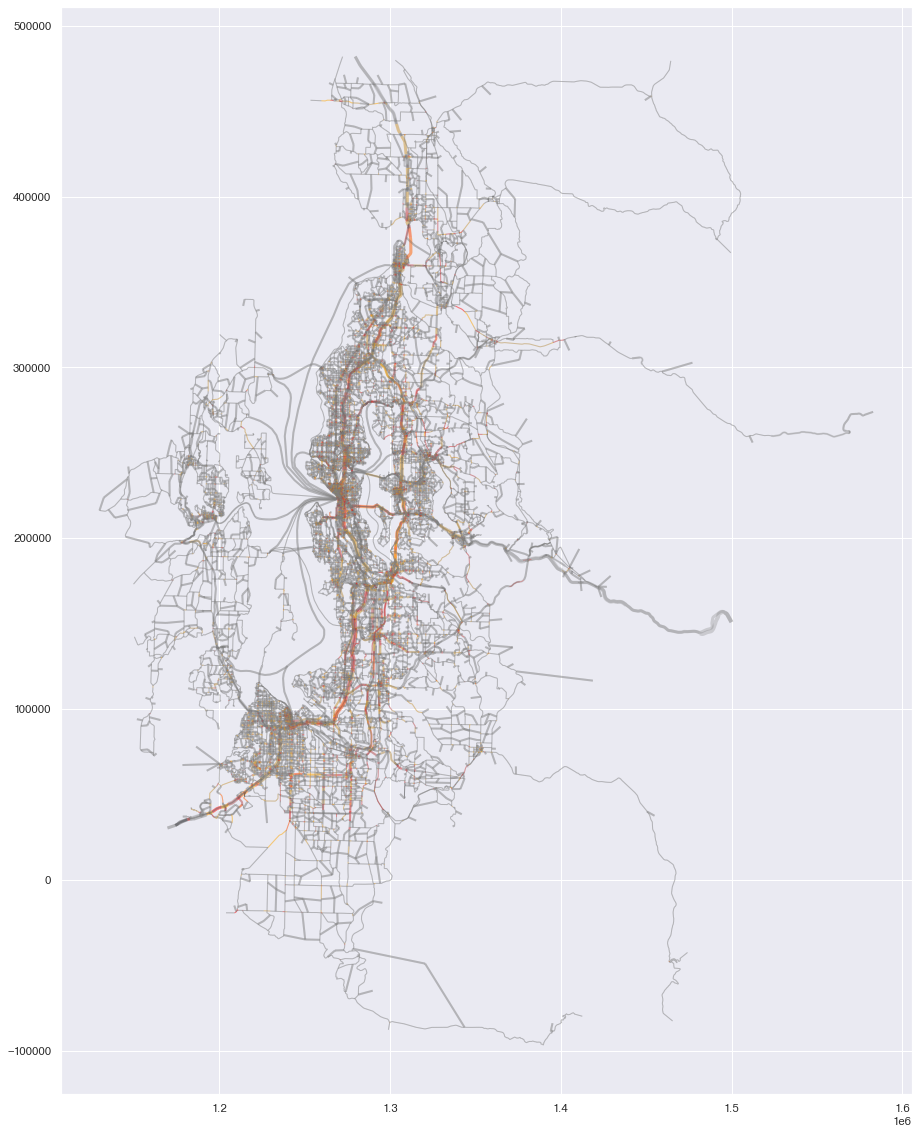

In [7]:
gdf = gpd.read_file(r'../../../inputs/scenario/networks/shapefiles/AM/AM_edges.shp')
gdf.columns
crs = {'init' : 'EPSG:2285'}
gdf.crs = crs
df = load_network_summary(r'../../../outputs/network/network_results.csv')
df.columns
# NOTE: for visualization, do not show connectors
df = df[df['data3'] != 5]
gdf = gdf.merge(df[df['tod'] == '7to8'][['ij','congestion_index','congestion_category']], left_on='id', right_on='ij', how='left')
gdf['congestion_category'] = gdf['congestion_category'].fillna('Light')
color_mapping = {'Light': 'grey','Moderate': 'orange','Heavy': 'red','Severe':'black'}
gdf.plot(color=gdf["congestion_category"].map(color_mapping), alpha=0.3, linewidth=gdf['lanes'], figsize=(20,20)) 


### PM (5-6)

<AxesSubplot:>

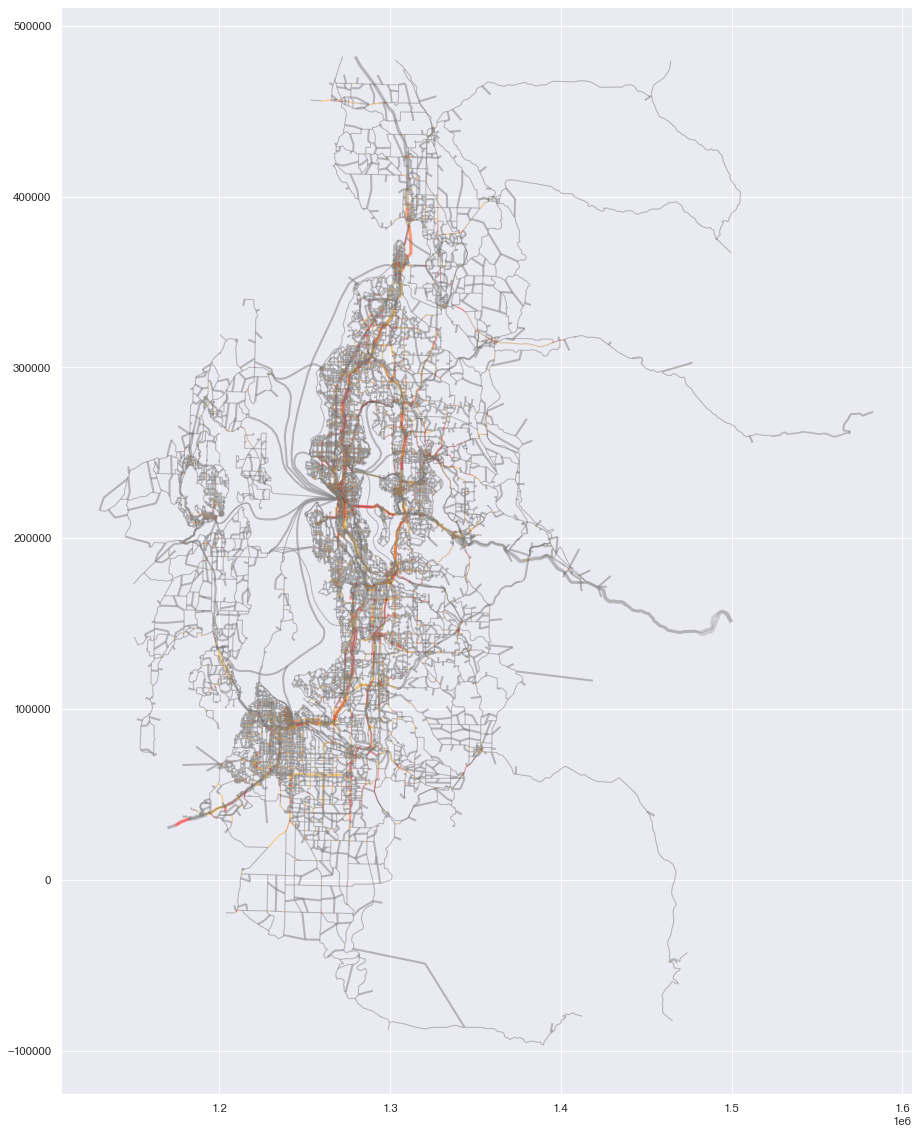

In [8]:
# AM
gdf = gpd.read_file(r'../../../inputs/scenario/networks/shapefiles/AM/AM_edges.shp')
gdf.columns
crs = {'init' : 'EPSG:2285'}
gdf.crs = crs
df = load_network_summary(r'../../../outputs/network/network_results.csv')
df.columns
# NOTE: for visualization, do not show connectors
df = df[df['data3'] != 5]
gdf = gdf.merge(df[df['tod'] == '17to18'][['ij','congestion_index','congestion_category']], left_on='id', right_on='ij', how='left')
gdf.columns
gdf['congestion_category'] = gdf['congestion_category'].fillna('Light')
color_mapping = {'Light': 'grey','Moderate': 'orange','Heavy': 'red','Severe':'black'}
gdf.to_file(r'../../../outputs/network/17to18.shp')
gdf.plot(color=gdf["congestion_category"].map(color_mapping), alpha=0.3, linewidth=gdf['lanes'], figsize=(20,20)) 


# Congestion by County

In [9]:
# County + Region by Roadway Type
df = load_network_summary(r'../../../outputs/network/network_results.csv')

In [10]:
pd.options.display.float_format = '{:0,.1%}'.format

AM Peak (7 to 8)

In [11]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df['Region'] = _df.sum(axis=1)
_df

,King,Kitsap,Pierce,Snohomish,Region
Light,"2,257,189","368,878","1,088,801","964,623","4,679,490"
Moderate,"692,311","20,783","271,772","281,472","1,266,338"
Heavy,"615,285","4,500","177,236","147,500","944,520"
Severe,"59,058","7,035","39,990","16,619","122,701"


In [12]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish,Region
Light,62.3%,91.9%,69.0%,68.4%,66.7%
Moderate,19.1%,5.2%,17.2%,20.0%,18.1%
Heavy,17.0%,1.1%,11.2%,10.5%,13.5%
Severe,1.6%,1.8%,2.5%,1.2%,1.7%


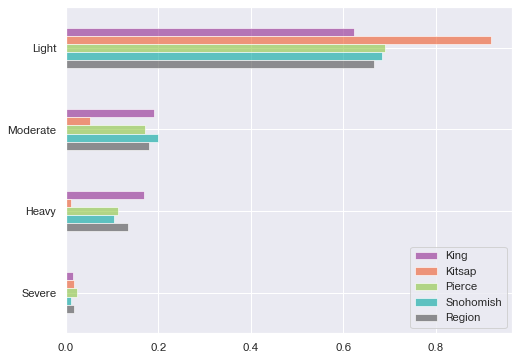

In [13]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

PM Peak (5 to 6)

In [14]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df['Region'] = _df.sum(axis=1)
_df

,King,Kitsap,Pierce,Snohomish,Region
Light,"2,578,099","423,559","1,213,322","1,096,145","5,311,126"
Moderate,"798,940","17,142","334,174","292,722","1,442,977"
Heavy,"654,623","6,347","183,042","179,941","1,023,953"
Severe,"69,461","7,695","13,917","17,610","108,683"


In [15]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish,Region
Light,62.9%,93.1%,69.6%,69.1%,67.3%
Moderate,19.5%,3.8%,19.2%,18.5%,18.3%
Heavy,16.0%,1.4%,10.5%,11.3%,13.0%
Severe,1.7%,1.7%,0.8%,1.1%,1.4%


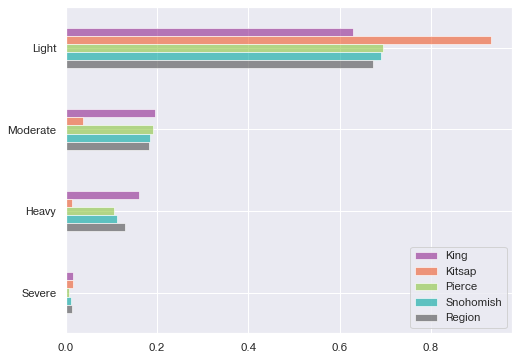

In [16]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

# Congestion by Road Type

AM Peak (7 to 8)

In [17]:
# County + Region by Roadway Type
df = load_network_summary(r'../../../outputs/network/network_results.csv')

In [18]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='facility_type',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,arterial,connector,highway
Light,"2,399,587","382,979","1,940,798"
Moderate,"436,677",NaN,"829,661"
Heavy,"293,557",NaN,"651,502"
Severe,"47,892",NaN,"74,810"


In [19]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,arterial,connector,highway
Light,75.5%,100.0%,55.5%
Moderate,13.7%,NaN,23.7%
Heavy,9.2%,NaN,18.6%
Severe,1.5%,NaN,2.1%


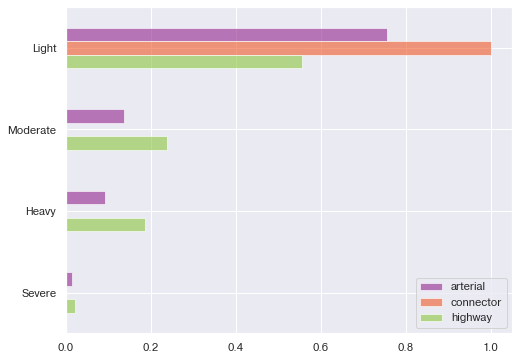

In [20]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

PM Peak (5 to 6)

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='facility_type',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,arterial,connector,highway
Light,"2,797,146","511,612","2,042,191"
Moderate,"537,458",NaN,"905,518"
Heavy,"348,902",NaN,"675,053"
Severe,"62,777",NaN,"46,593"


In [22]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,arterial,connector,highway
Light,74.7%,100.0%,55.7%
Moderate,14.3%,NaN,24.7%
Heavy,9.3%,NaN,18.4%
Severe,1.7%,NaN,1.3%


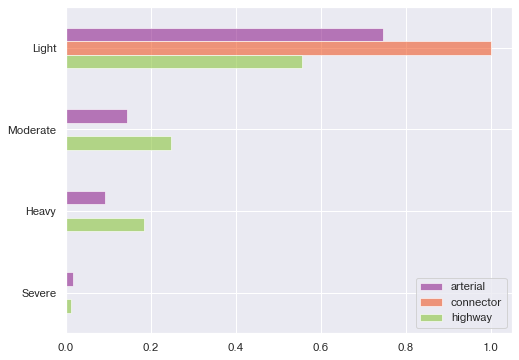

In [23]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

# Congestion within Equity Geography Areas
Daily Totals within Equity Geographies versus Region

In [24]:
def read_from_sde(connection_string, feature_class_name, version,
                  crs={'init': 'epsg:2285'}, is_table = False):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """


    engine = sqlalchemy.create_engine(connection_string)
    con=engine.connect()
    #con.execute("sde.set_current_version {0}".format(version))
    if is_table:
        gdf=pd.read_sql('select * from %s' % 
                   (feature_class_name), con=con)
        con.close()

    else:
        df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
        con.close()

        df['geometry'] = df['geometry'].apply(wkt.loads)
        gdf=gpd.GeoDataFrame(df, geometry='geometry')
        gdf.crs = crs
        cols = [col for col in gdf.columns if col not in 
                ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
        gdf = gdf[cols]
    
    return gdf


In [25]:
def intersect_geog(geog, tract_gdf, gdf_network, df):
    
    # Load Elmer database to identify tracts within equity geographies
    conn_string =  "DRIVER={{ODBC Driver 17 for SQL Server}}; SERVER={}; DATABASE=Elmer; trusted_connection=yes".format('AWS-PROD-SQL\Sockeye')
    sql_conn = pyodbc.connect(conn_string)
    sql_text = "select geoid, equity_geog_vs_50_percent, equity_geog_vs_reg_total from census."+geog+"(2019, 'Tract')"
    sql_df = pd.read_sql(sql=sql_text, con=sql_conn)

    gdf_shp = tract_gdf.merge(sql_df, left_on='geoid10', right_on='geoid', how='left')
    gdf_shp = gdf_shp[gdf_shp['equity_geog_vs_reg_total'] == 1]    # Note this is standard for each equity geog

    # Intersect geography this with the network shapefile

    gdf_intersect = gpd.overlay(gdf_network, gdf_shp, how="union", keep_geom_type=False)

    # # Will need to relaculate the lengths since some were split across the regional geographies
    gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

    # ### IMPORTANT
    # # filter out the polygon results and only keep lines
    gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]
    
    df = df[['@tveh','congestion_category','i_node','j_node','length','tod','total_delay']].merge(gdf_intersect, 
                                                             left_on=['i_node','j_node'],
                                                            right_on=['i','j'],
                                                                  how='left')
    
    # calculate total delay
    df['delay'] = (df['new_length']/df['length_x'])*df['total_delay']
    # Note that we won't get all of the data because some links are outside the region boundaries
    # Optionally, scale these numbers by the total delay field total_delay for consistency
    df['scaled_delay'] = df['delay']*(df['total_delay'].sum()/df['delay'].sum())
    
    return df

In [26]:
# Load  tract geographies from ElmerGeo
connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/ElmerGeo?driver=SQL Server?Trusted_Connection=yes'
crs = {'init' : 'EPSG:2285'}
version = "'DBO.Default'"
gdf_shp = read_from_sde(connection_string, 'tract2010', version, crs=crs, is_table=False)

gdf_network = gpd.read_file(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
gdf_network.crs = crs



In [27]:
df_network = load_network_summary(r'../../../outputs/network/network_results.csv')
df = intersect_geog('poverty_equity_geographies', gdf_shp, gdf_network, df_network)

In [28]:
####################
####

results_df = pd.DataFrame()
#### Loop through each equity geog
for geog in ['poverty_equity_geographies','racial_equity_geographies']:
    df = intersect_geog(geog, gdf_shp, gdf_network, df_network)
    df['source'] = geog
    results_df = results_df.append(df)

In [29]:
# results_df

In [30]:
pd.options.display.float_format = '{:0,.0f}'.format
final_df = pd.DataFrame()
for geog in ['poverty_equity_geographies','racial_equity_geographies']:

    df= results_df[results_df['source'] == geog]
    df['new_VMT'] = df['new_length'] * df['@tveh']

    pd.options.display.float_format = '{:0,.0f}'.format
    _df = df[df['equity_geog_vs_reg_total'] == 1]
    _df = _df.pivot_table(index='congestion_category',columns='equity_geog_vs_reg_total',
                   aggfunc='sum',values='new_VMT')
    _df = _df.reindex(['Light','Moderate','Heavy','Severe'])
    _df.index.name = None
    _df.columns.name = None
    final_df[geog] = _df[1]
final_df.rename(columns={'poverty_equity_geographies':'Poverty', 'racial_equity_geographies':'Racial'},
               inplace=True)

df = load_network_summary(r'../../../outputs/network/network_results.csv')
_df = df.groupby('congestion_category').sum()[['VMT']]
final_df = _df.merge(final_df, left_index=True, right_index=True)
final_df.rename(columns={'VMT': 'Region'}, inplace=True)
final_df

,Region,Poverty,Racial
Heavy,"5,694,680","2,842,323","3,505,151"
Light,"76,103,909","35,009,230","37,799,362"
Moderate,"10,683,764","5,393,975","6,505,791"
Severe,"603,363","278,711","353,504"


In [31]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = final_df/final_df.sum(axis=0)
_df

,Region,Poverty,Racial
Heavy,6.1%,6.5%,7.3%
Light,81.8%,80.4%,78.5%
Moderate,11.5%,12.4%,13.5%
Severe,0.6%,0.6%,0.7%
